# Rectify musical scores

Standardize dirty music sheets

## Import necessary libraries and data

In [1]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure
%matplotlib inline
import ipywidgets as widgets
import numpy as np
import skimage
from skimage import io, color, exposure, filters, feature, transform, draw, morphology, measure
from skimage.filters.thresholding import _cross_entropy

from typing import Generator, Tuple
from pathlib import Path
from scorectify.loader import load
from PIL import Image, ImageOps

Now prepare to load the sample data

In [2]:
data_dir = Path('dirty_scores')
edge_cases_dir = data_dir / Path('edge_cases')
generated_dir = data_dir / Path('generated')
oh_boy_dir = data_dir / Path('oh_boy')
scanned_dir = data_dir / Path('scanned')
yellowed_and_skewed_dir = data_dir / Path('yellowed_and_skewed')
data = {
    'edge_cases': {
        edge_cases_dir / Path('IMSLP297685-PMLP482515-Beeth_Damm_RSL.pdf'): [(3, 6)],
        scanned_dir / Path('IMSLP339560-SIBLEY1802.15728.b6b8-39087004901080score.pdf'): [(2, 2)]
    },
    'generated': {
        generated_dir / Path('IMSLP678273-PMLP148731-BeeC2.pdf'): [(1, 1)]
    },
    'oh_boy': {
        oh_boy_dir / Path('IMSLP51445-PMLP16883-WoO_79.pdf'): [(2, 9)],
        yellowed_and_skewed_dir / Path('IMSLP284829-PMLP462408-Beeth_Rein_Her_VS_1_ed.pdf'): [(5, 41)]  # Handwritten annotations
    },
    'scanned': {
        scanned_dir / Path('IMSLP51817-PMLP96125-Beethoven_Werke_Breitkopf_Serie_16_No_161_Zwei_Leichte_Sonaten_No_2_in_F.pdf'): [
            (1, 4)
        ],
        scanned_dir / Path('IMSLP74149-PMLP148731-285.pdf') : [(1, 2)],  # Wobbly
        scanned_dir / Path('IMSLP296418-PMLP480620-B_VS_all_sc.pdf'): [(3, 205)],
        scanned_dir / Path('IMSLP339560-SIBLEY1802.15728.b6b8-39087004901080score.pdf'): [(3, 205)]  # No, this is not an error
    },
    'yellowed_and_skewed': {
        yellowed_and_skewed_dir / Path('IMSLP284829-PMLP462408-Beeth_Rein_Her_VS_1_ed.pdf'): [(5, 41), (47, 163)]
    }
}

# Make sure all those files exist
for classification in data.keys():
    for file in data[classification].keys():
        if not file.exists():
            print(f"File does not exist!\n  - {file}")

In [3]:
def load_cont(classification: str, data: dict = data) -> Generator[Image.Image, None, None]:
    for path, idxs in data[classification].items():
        assert path.exists()
        for idx_from, idx_to in idxs:
            for idx in range(idx_from, idx_to + 1):
                yield load(path, dpi=250, first_page=idx, last_page=idx)[0]

edge_cases = load_cont('edge_cases')
generated = load_cont('generated')
oh_boy = load_cont('oh_boy')
scanned = load_cont('scanned')
yellowed_and_skewed = load_cont('yellowed_and_skewed')

control_group = load_cont('generated')

Actually load one page of each class into memory

In [4]:
edge_case_0_orig = next(edge_cases)
generated_0_orig = next(generated)
oh_boy_0_orig = next(oh_boy)
scanned_0_orig = next(scanned)
yellowed_and_skewed_0_orig = next(yellowed_and_skewed)

control_group_0_orig = next(control_group)

Make a simple plot function for all class samples and plot the loaded samples

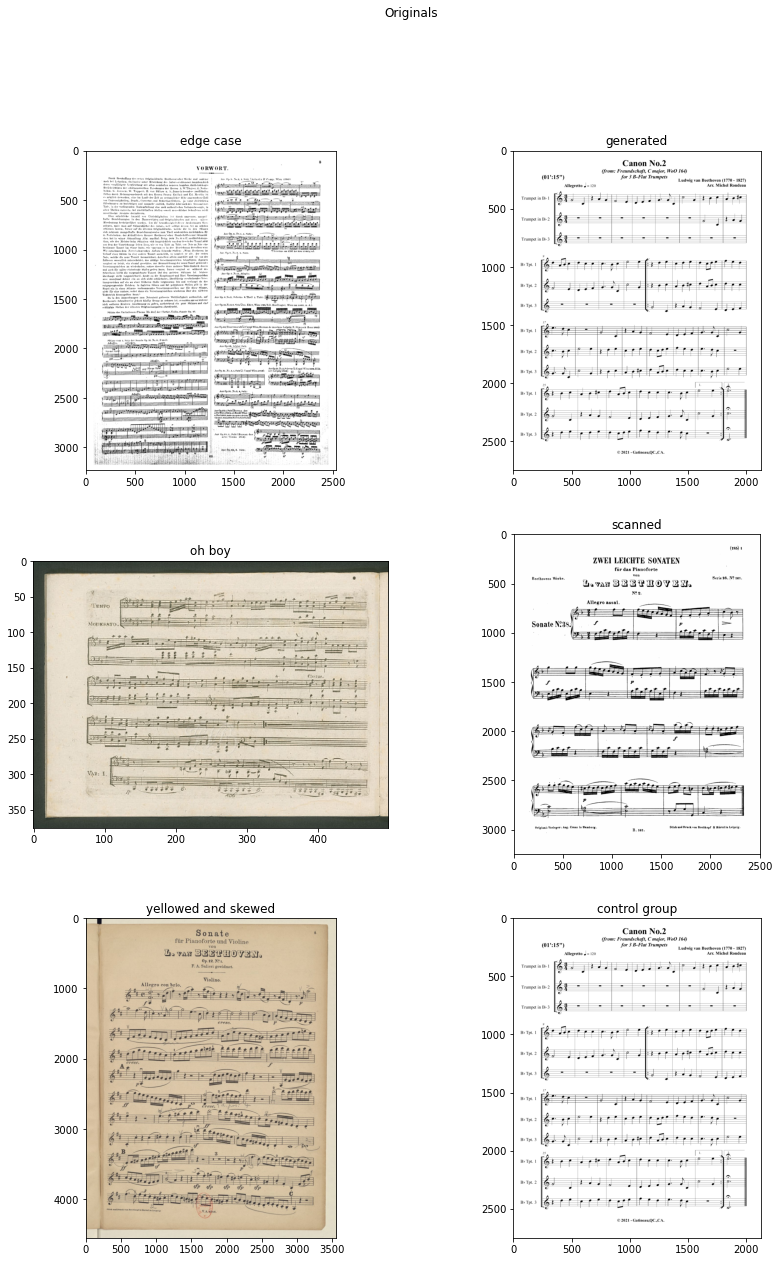

In [5]:
# plt.imshow(edge_case_0)
def plot_images(edge_case, generated, oh_boy, scanned, yellowed_and_skewed, control_group, title: str) -> Tuple[Figure, Axes]:
    fig = plt.figure(figsize=(14, 20))
    _ = fig.suptitle(title)
    axs = fig.subplots(ncols=2, nrows=3)
    axs[0][0].imshow(edge_case, cmap='gray')
    axs[0][0].set_title('edge case')
    axs[0][1].imshow(generated, cmap='gray')
    axs[0][1].set_title('generated')
    axs[1][0].imshow(oh_boy, cmap='gray')
    axs[1][0].set_title('oh boy')
    axs[1][1].imshow(scanned, cmap='gray')
    axs[1][1].set_title('scanned')
    axs[2][0].imshow(yellowed_and_skewed, cmap='gray')
    axs[2][0].set_title('yellowed and skewed')
    axs[2][1].imshow(control_group, cmap='gray')
    axs[2][1].set_title('control group')
    return fig, axs

fig, axs = plot_images(
    edge_case_0_orig,
    generated_0_orig,
    oh_boy_0_orig,
    scanned_0_orig,
    yellowed_and_skewed_0_orig,
    control_group_0_orig,
    'Originals'
)

(<Figure size 1008x1440 with 1 Axes>,
 <AxesSubplot:title={'center':'Oh boy sample'}>)

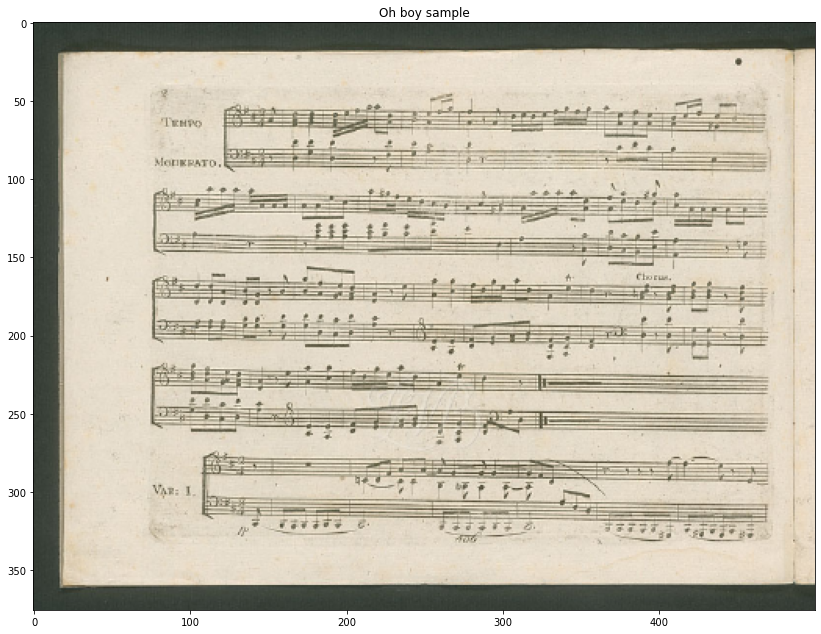

In [6]:
# For inspection of a specific sample in high resolution
def plot_image(im: np.ndarray, title: str) -> Tuple[Figure, Axes]:
    fig = plt.figure(figsize=(14, 20))
#     _ = fig.suptitle(title)
    axis = fig.add_subplot()
    axis.imshow(im, cmap='gray')
    axis.set_title(title)
    return fig, axis

plot_image(oh_boy_0_orig, 'Oh boy sample')

## Make grayscale images

The output should be grayscale as well.
Therefore we base all our computations on grayscale images.

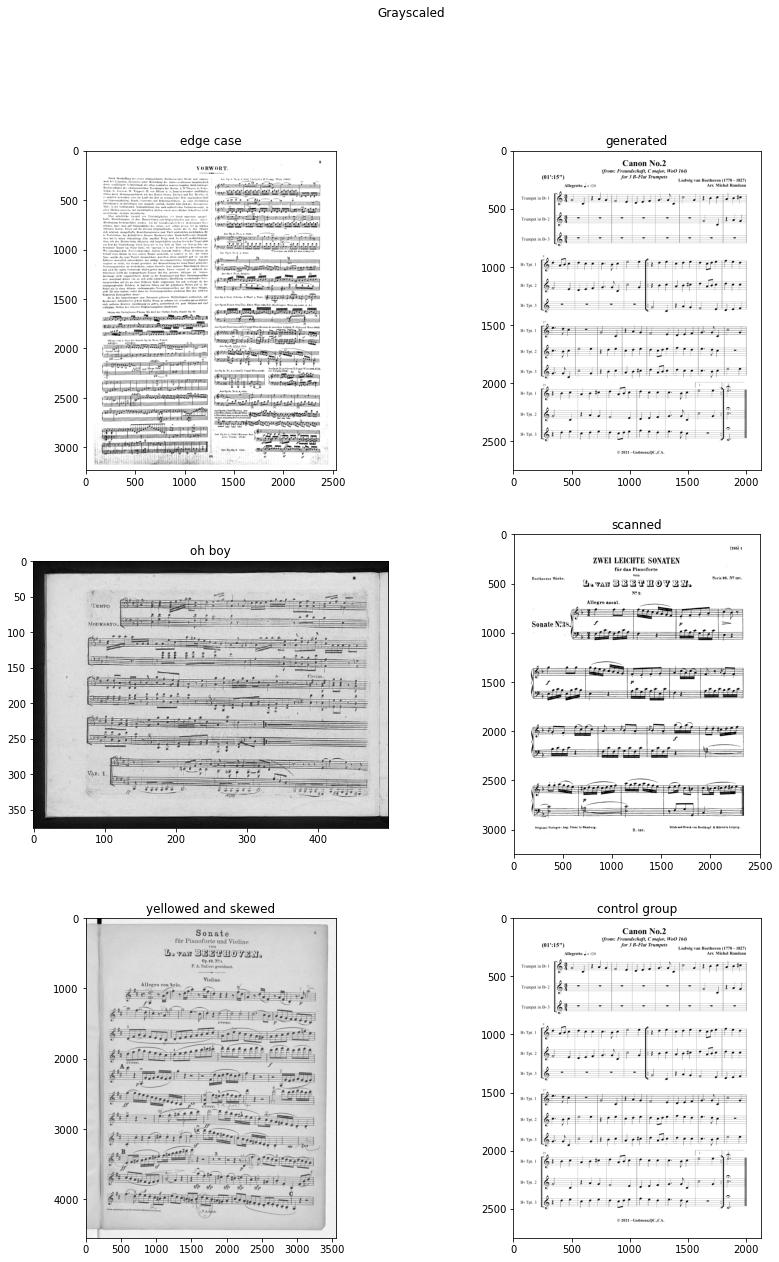

In [7]:
edge_case_0_gray = np.array(ImageOps.grayscale(edge_case_0_orig))
generated_0_gray = np.array(ImageOps.grayscale(generated_0_orig))
oh_boy_0_gray = np.array(ImageOps.grayscale(oh_boy_0_orig))
scanned_0_gray = np.array(ImageOps.grayscale(scanned_0_orig))
yellowed_and_skewed_0_gray = np.array(ImageOps.grayscale(yellowed_and_skewed_0_orig))
control_group_0_gray = np.array(ImageOps.grayscale(control_group_0_orig))

fig, axs = plot_images(
    edge_case_0_gray,
    generated_0_gray,
    oh_boy_0_gray,
    scanned_0_gray,
    yellowed_and_skewed_0_gray,
    control_group_0_gray,
    'Grayscaled'
)

## Fix rotation

Detect the possible deviant rotation of the music sheet and correct for it

### Find the stem lines to determine the rotation

#### Threshold the image

Accentuate the stem lines by using an appropriate thresholding

In [8]:
from skimage.transform import hough_line, hough_line_peaks

from skimage.filters import threshold_yen

def find_right_thresholding(im: np.ndarray):
    from skimage.filters import try_all_threshold
    fig, ax = try_all_threshold(im, figsize=(100, 120), verbose=False)
    plt.show()

# find_right_thresholding(edge_case_0_gray)
# find_right_thresholding(generated_0_gray)
# find_right_thresholding(oh_boy_0_gray)
# find_right_thresholding(scanned_0_gray)
# find_right_thresholding(yellowed_and_skewed_0_gray)
# find_right_thresholding(control_group_0_gray)

* Li and Minimum completely erase stems on the oh-boy sample
* Isodata and Otsu give bad results on many lines on the oh-boy sample
* Minimum whites out too much of the yellowed-and-skewed sample
* Triangle and Mean create a black border for the yellowed-and-skewed sample

$\Rightarrow$ Use Yen thresholding

In [9]:
def threshold(im: np.ndarray, invert: bool = True) -> np.ndarray:
    thresh = threshold_yen(im)
    if invert:
        return im < thresh
    return im > thresh

### Accentuate stem lines

Make sure dirty stem lines are clearly visible for detecting their orientation

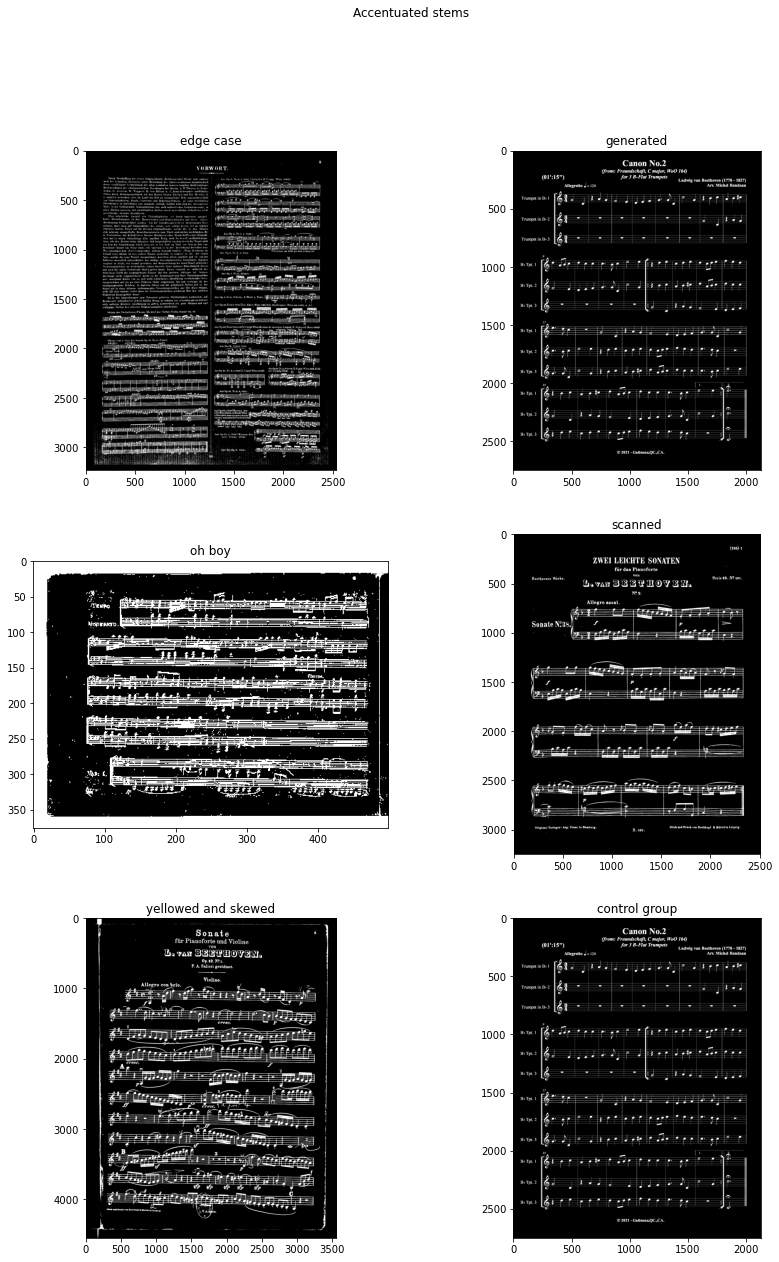

In [10]:
from skimage.morphology import dilation, square
def accentuate_stems(im: np.ndarray, dilation_size: int) -> np.ndarray:
    im_th = im < threshold_yen(im)
    im_dil = dilation(im_th, square(dilation_size))
    return im_dil

edge_case_0_stems = accentuate_stems(edge_case_0_gray, 1)
generated_0_stems = accentuate_stems(generated_0_gray, 1)
oh_boy_0_stems = accentuate_stems(oh_boy_0_gray, 1)
scanned_0_stems = accentuate_stems(scanned_0_gray, 1)
yellowed_and_skewed_0_stems = accentuate_stems(yellowed_and_skewed_0_gray, 1)
control_group_0_stems = accentuate_stems(control_group_0_gray, 1)

fig, axs = plot_images(
    edge_case_0_stems,
    generated_0_stems,
    oh_boy_0_stems,
    scanned_0_stems,
    yellowed_and_skewed_0_stems,
    control_group_0_stems,
    'Accentuated stems'
)

### Detect rotation

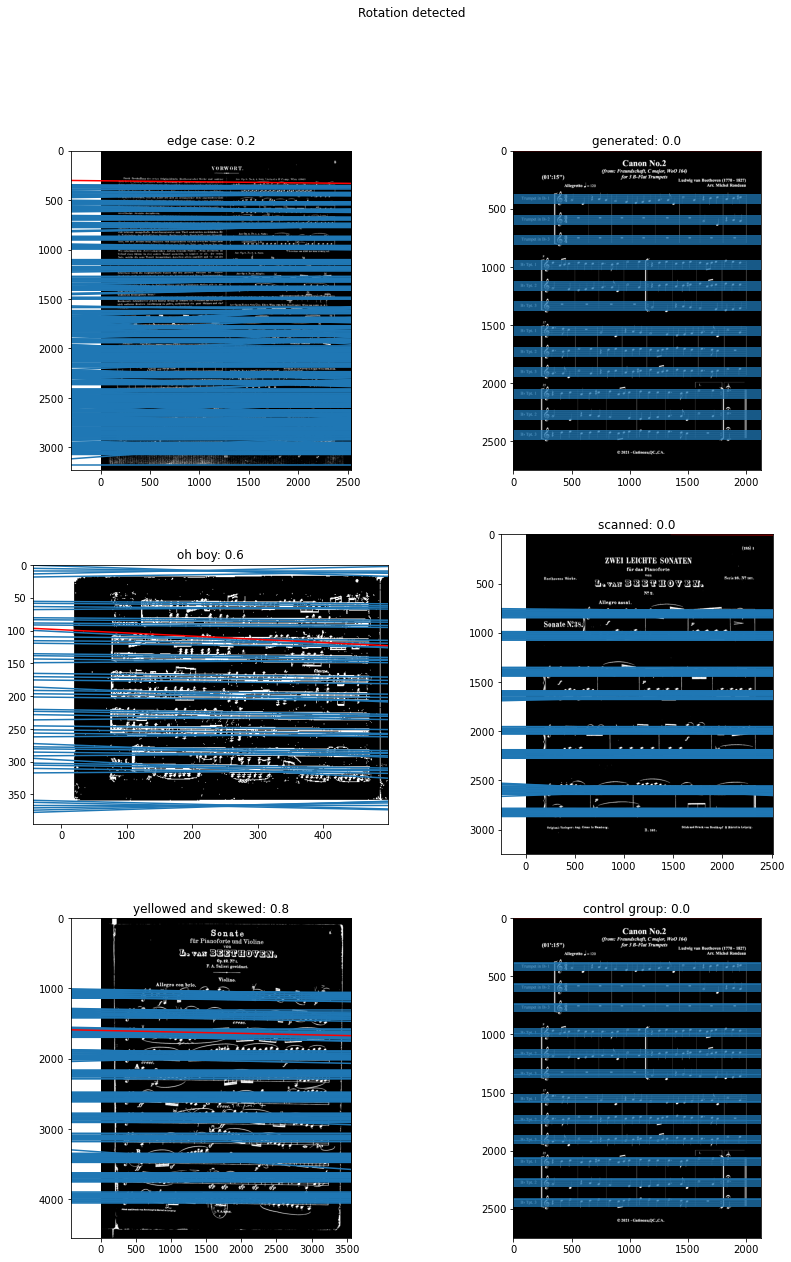

In [11]:
def detect_rotation(im: np.ndarray, axis: Axes):
    max_angle = np.pi / 18 / 2  # ±5°
    graining = 50
    possible_angles = np.linspace(-max_angle+np.pi/2, max_angle+np.pi/2, graining, endpoint=False)
    h, theta, d = hough_line(im, theta=possible_angles)
    
    _, angles, dists = hough_line_peaks(h, theta, d, min_distance=2)
    for angle, dist in zip(angles, dists):
        (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
        axis.axline((x0, y0), slope=np.tan(angle + np.pi/2))
    
    angles = np.array(sorted(angles)) - np.pi/2
    best_angle = np.rad2deg(np.median(angles))
    (x0, y0) = im.shape[0] * 0.5 * np.array([np.cos(best_angle), np.sin(best_angle)])
    axis.axline((x0, y0), slope=np.tan(angle + np.pi/2), color='r')
    axis.set_title(f"{axis.get_title()}: {best_angle:.05}")
    return best_angle

fig, axs = plot_images(
    edge_case_0_stems,
    generated_0_stems,
    oh_boy_0_stems,
    scanned_0_stems,
    yellowed_and_skewed_0_stems,
    control_group_0_stems,
    'Rotation detected'
)

edge_case_0_angle = detect_rotation(edge_case_0_stems, axs[0][0])
generated_0_angle = detect_rotation(generated_0_stems, axs[0][1])
oh_boy_0_angle = detect_rotation(oh_boy_0_stems, axs[1][0])
scanned_0_angle = detect_rotation(scanned_0_stems, axs[1][1])
yellowed_and_skewed_0_angle = detect_rotation(yellowed_and_skewed_0_stems, axs[2][0])
control_group_0_angle = detect_rotation(control_group_0_stems, axs[2][1])

# _, axis = plot_image(oh_boy_0_stems, 'Rotation detected - oh boy sample')
# detect_rotation(oh_boy_0_stems, axis)
# _, axis = plot_image(scanned_0_stems, 'Rotation detected - scanned sample')
# detect_rotation(scanned_0_stems, axis)
# _, axis = plot_image(edge_case_0_stems, 'Rotation detected - edge case sample')
# detect_rotation(edge_case_0_stems, axis)

### Correct Rotation

Decide on the threshold above which to correct for rotation.
A reasonable value seems to be around 0.005°.

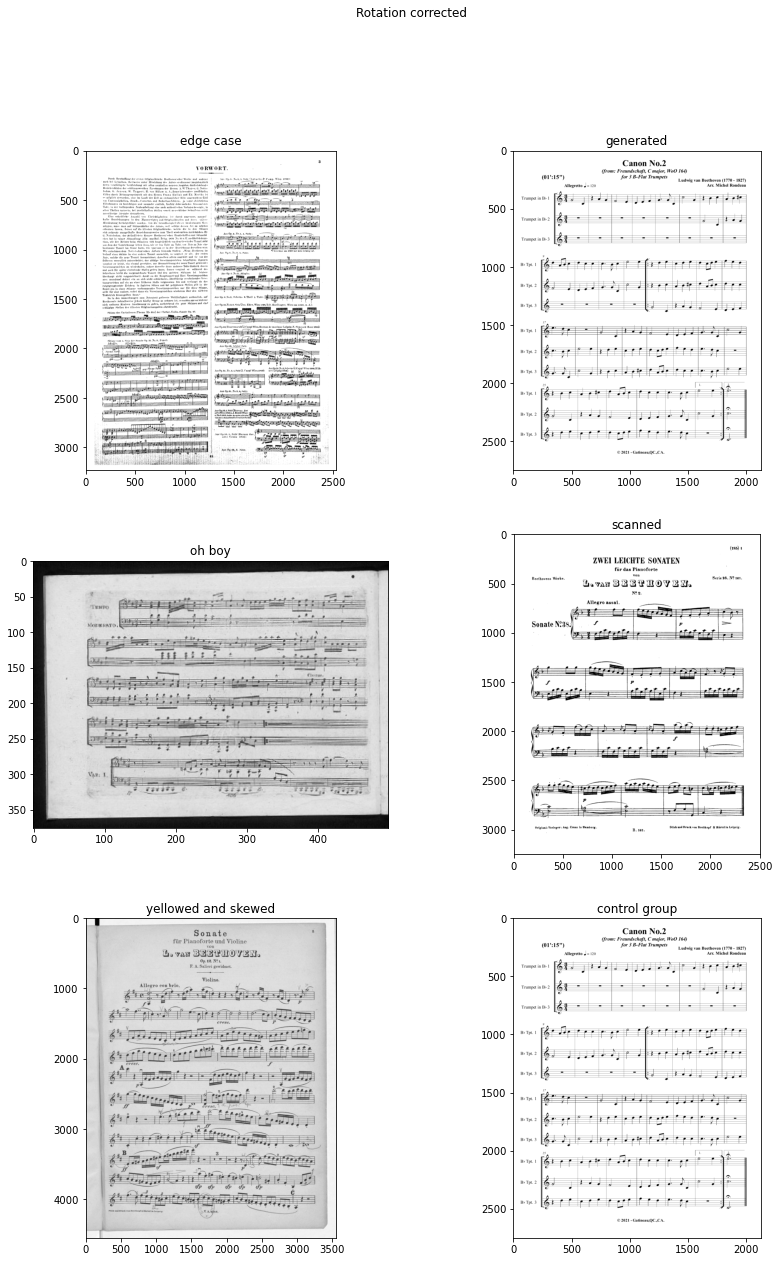

In [12]:
from skimage.transform import rotate
rotation_threshold = 0.005

edge_case_0_corr = rotate(edge_case_0_gray, edge_case_0_angle, mode='edge') if edge_case_0_angle > rotation_threshold else edge_case_0_gray
generated_0_corr = rotate(generated_0_gray, generated_0_angle, mode='edge') if generated_0_angle > rotation_threshold else generated_0_gray
oh_boy_0_corr = rotate(oh_boy_0_gray, oh_boy_0_angle, mode='edge') if oh_boy_0_angle > rotation_threshold else oh_boy_0_gray
scanned_0_corr = rotate(scanned_0_gray, scanned_0_angle, mode='edge') if scanned_0_angle > rotation_threshold else scanned_0_gray
yellowed_and_skewed_0_corr = rotate(yellowed_and_skewed_0_gray, yellowed_and_skewed_0_angle, mode='edge') if yellowed_and_skewed_0_angle > rotation_threshold else yellowed_and_skewed_0_gray
control_group_0_corr = rotate(control_group_0_gray, control_group_0_angle, mode='edge') if control_group_0_angle > rotation_threshold else control_group_0_gray

fig, axs = plot_images(
    edge_case_0_corr,
    generated_0_corr,
    oh_boy_0_corr,
    scanned_0_corr,
    yellowed_and_skewed_0_corr,
    control_group_0_corr,
    'Rotation corrected'
)

## Re-threshold images

Binarize the image using a threshold

(<Figure size 1008x1440 with 1 Axes>,
 <AxesSubplot:title={'center':'Oh boy sample'}>)

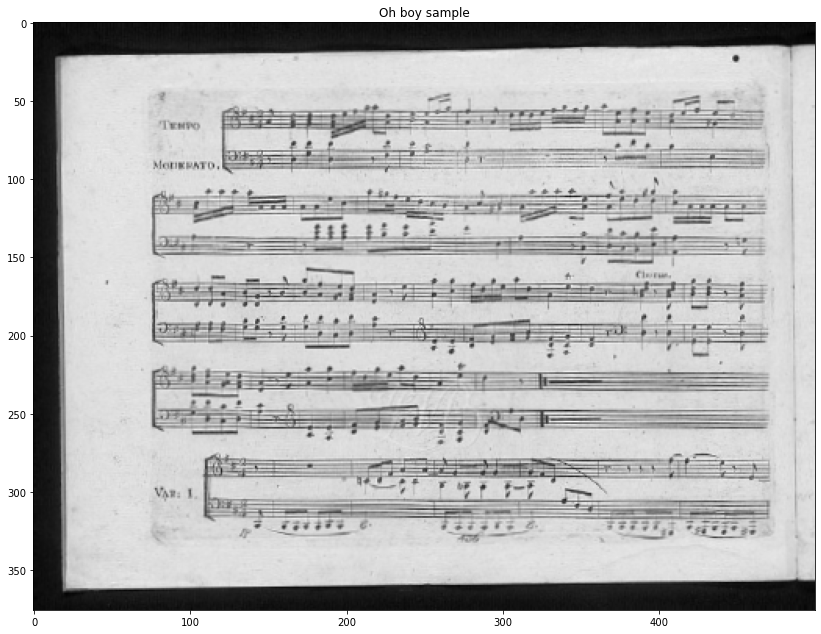

In [13]:
plot_image(oh_boy_0_corr, 'Oh boy sample')

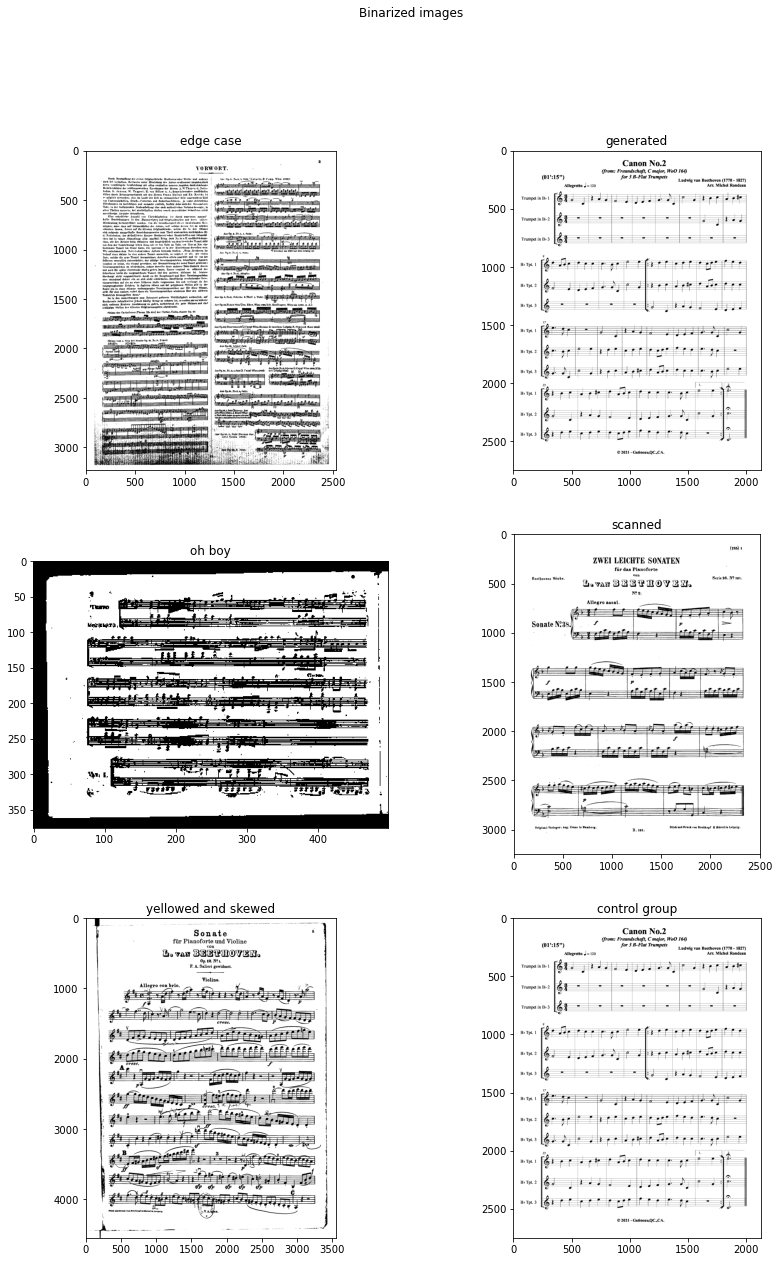

In [14]:
edge_case_0_thresh = threshold(edge_case_0_corr, invert=False)
generated_0_thresh = threshold(generated_0_corr, invert=False)
oh_boy_0_thresh = threshold(oh_boy_0_corr, invert=False)
scanned_0_thresh = threshold(scanned_0_corr, invert=False)
yellowed_and_skewed_0_thresh = threshold(yellowed_and_skewed_0_corr, invert=False)
control_group_0_thresh = threshold(control_group_0_corr, invert=False)

fig, axs = plot_images(
    edge_case_0_thresh,
    generated_0_thresh,
    oh_boy_0_thresh,
    scanned_0_thresh,
    yellowed_and_skewed_0_thresh,
    control_group_0_thresh,
    'Binarized images'
)

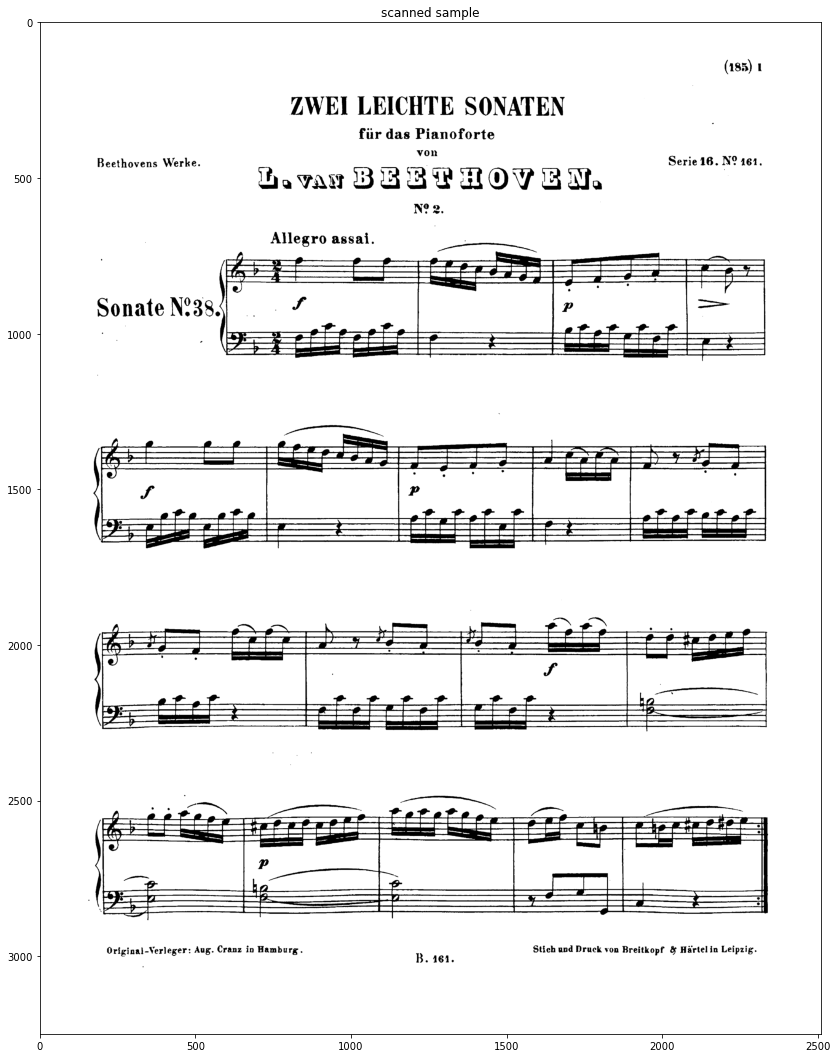

In [15]:
_, _ = plot_image(scanned_0_corr, 'scanned sample')

In [16]:
from skimage.transform import probabilistic_hough_line
from skimage.feature import canny

# Line finding using the Probabilistic Hough Transform
image = scanned_0_corr
edges = canny(image, 2, 1, 25)
lines = probabilistic_hough_line(
    edges,
    threshold=10,
    line_length=7,
    line_gap=2,
    theta=np.linspace(-np.pi/18, np.pi/18, 50) + np.pi/2
)

# # Generating figure 2
# fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
# ax = axes.ravel()

# ax[0].imshow(image, cmap='gray')
# ax[0].set_title('Input image')

# ax[1].imshow(edges, cmap='gray')
# ax[1].set_title('Canny edges')

# ax[2].imshow(edges * 0)
# for line in lines:
#     p0, p1 = line
#     ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
# ax[2].set_xlim((0, image.shape[1]))
# ax[2].set_ylim((image.shape[0], 0))
# ax[2].set_title('Probabilistic Hough')

# for a in ax:
#     a.set_axis_off()

# plt.tight_layout()
# plt.show()


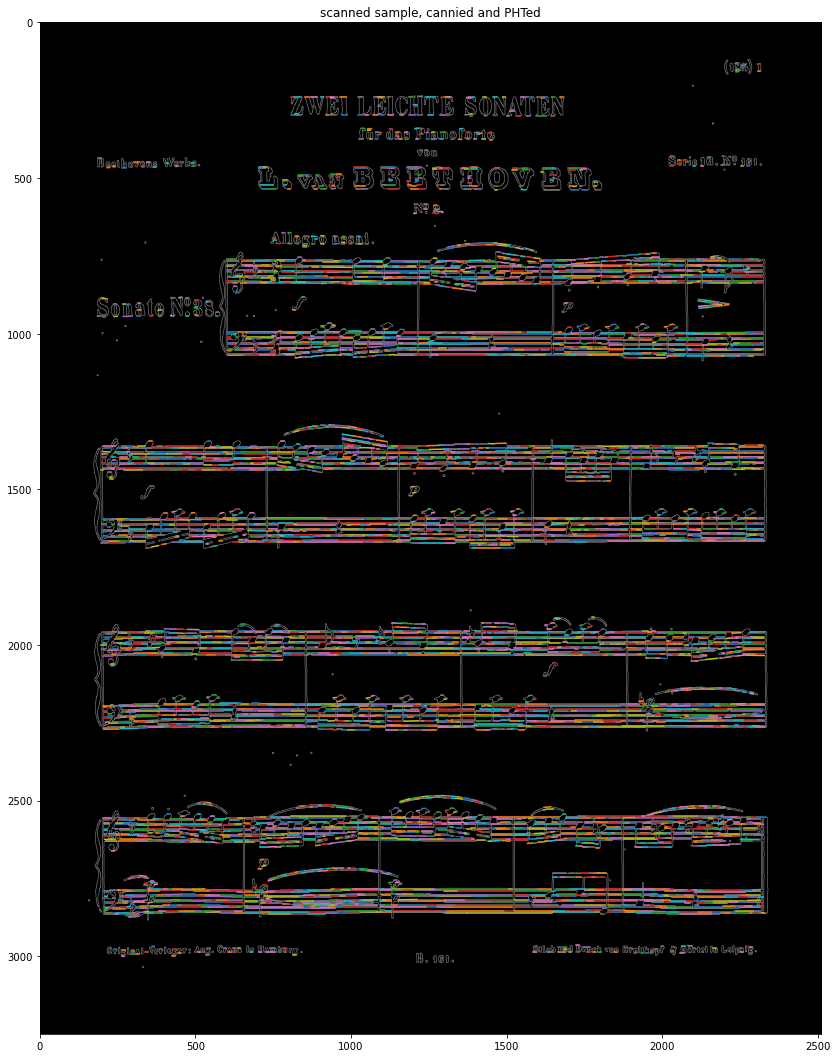

In [17]:
fig, axis = plot_image(edges, 'scanned sample, cannied and PHTed')
for line in lines:
    p0, p1 = line
    axis.plot((p0[0], p1[0]), (p0[1], p1[1]))


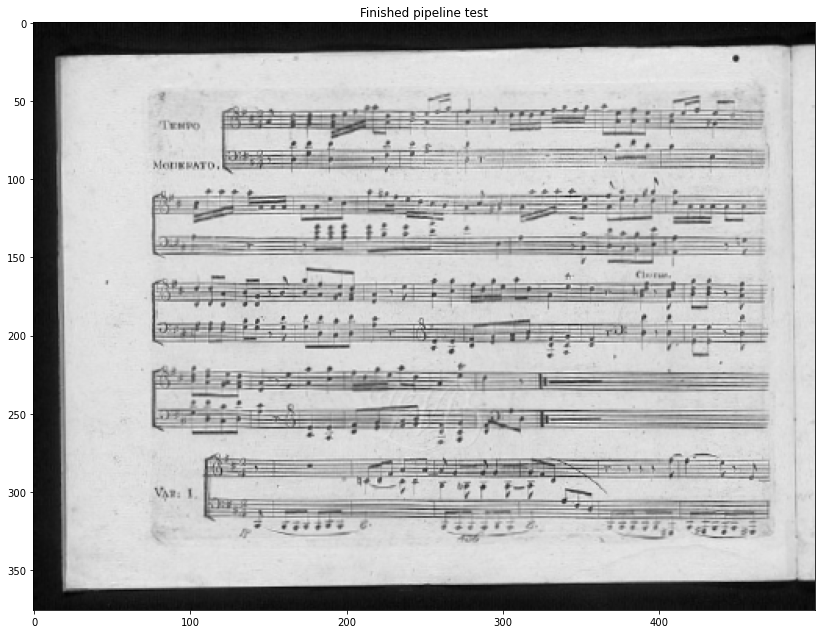

In [18]:
from scorectify.main import rectify_image

_, _ = plot_image(rectify_image(oh_boy_0_orig), 'Finished pipeline test')